# Step 1: Importing Necessary Libraries

In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.ops as ops
import pandas as pd


# Step 2: Data Preparation and Processing


1. **Data Loading**: Positive and negative images are loaded from specified directories, converted to grayscale, resized to a uniform size (100x40 pixels), and labeled accordingly.

2. **Data Preprocessing**: The images are normalized (pixel values scaled to [0, 1]) and reshaped to include a channel dimension, making them suitable for input to a CNN.

3. **Dataset Splitting**: The combined dataset is divided into training (65%) and validation (35%) sets for model evaluation and testing.

4. **Data Augmentation**: To improve the model's ability to generalize, various augmentation techniques such as rotation, zoom, and horizontal flipping are applied to the training images. This significantly increases the diversity of the dataset.

5. **Class Weight Computation**: To address potential class imbalance, class weights are calculated and will later be used during model training to ensure fair learning.

6. **Class Distribution Analysis**: The distribution of positive and negative samples is analyzed for both the training and validation datasets to verify label balance and confirm that augmentation is consistent.

This pipeline ensures that the image data is properly prepared and enhanced for training a robust and reliable CNN model for image classification.


In [2]:
# Define paths
train_pos_path = './CarData/TrainImages/pos-'
train_neg_path = './CarData/TrainImages/neg-'

# Initialize lists for images and labels
images = []
labels = []

# Load positive images (car)
for i in range(550):
    img_path = f'{train_pos_path}{i}.pgm'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100, 40))  # Resize to 100x40
    images.append(img)
    labels.append(1)  # Label for positive images (car)

# Load negative images (non-car)
for i in range(500):
    img_path = f'{train_neg_path}{i}.pgm'
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100, 40))  # Resize to 100x40
    images.append(img)
    labels.append(0)  # Label for negative images (non-car)

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize images
images = images.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

# Reshape images to add an extra channel dimension for CNN (as grayscale)
images = np.expand_dims(images, axis=-1)

# Split the data into training and validation sets first
train_data, val_data = train_test_split(list(zip(images, labels)), test_size=0.35, random_state=42)

# Unzip into separate lists for train and validation data
train_images, train_labels = zip(*train_data)
val_images, val_labels = zip(*val_data)

# Convert back to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Define the data augmentation generator for training images only
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Augment the training dataset by generating multiple augmented images per original image
augmented_images = []
augmented_labels = []

# Number of augmented images per original image
num_augmentations = 15  # You can increase this number as needed

# Generate augmented images only for the training data
for img, label in zip(train_images, train_labels):
    img = np.expand_dims(img, axis=0)  # Add batch dimension for augmentation
    label = np.array([label])  # Make sure label is a numpy array
    
    # Generate multiple augmented versions of each image
    augmented_batch = datagen.flow(img, label, batch_size=1)
    
    # Collect a set number of augmented images (num_augmentations)
    for _ in range(num_augmentations):
        augmented_image, augmented_label = augmented_batch.next()
        augmented_images.append(augmented_image[0])  # Add the augmented image
        augmented_labels.append(augmented_label[0])  # Add the label

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Print the number of images after augmentation
print(f'Number of augmented images after augmentation: {len(augmented_images)}')

# Compute class weights to handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Count the number of positive and negative labels in training data
train_pos_count = np.sum(augmented_labels == 1)
train_neg_count = np.sum(augmented_labels == 0)

# Count the number of positive and negative labels in validation data
val_pos_count = np.sum(val_labels == 1)
val_neg_count = np.sum(val_labels == 0)

# Print the distribution for training data
print(f'Training Data Distribution:')
print(f'Positive (car) images: {train_pos_count}')
print(f'Negative (non-car) images: {train_neg_count}')

# Print the distribution for validation data
print(f'\nValidation Data Distribution:')
print(f'Positive (car) images: {val_pos_count}')
print(f'Negative (non-car) images: {val_neg_count}')


Number of augmented images after augmentation: 10230
Training Data Distribution:
Positive (car) images: 5145
Negative (non-car) images: 5085

Validation Data Distribution:
Positive (car) images: 207
Negative (non-car) images: 161


# Step 3: Model Building

1. **CNN Architecture**:
   - A custom CNN class (`CarClassifierCNN`) is defined using PyTorch's `nn.Module`. 
   - The architecture consists of:
     - **Convolutional Layers**: Extract spatial features using 3 convolutional layers with ReLU activations and max-pooling for down-sampling.
     - **Fully Connected Layers**: Flattened feature maps are passed through dense layers to perform classification, with a final sigmoid layer for binary classification.

2. **Data Conversion**:
   - The augmented training images and labels are converted to PyTorch tensors and reshaped to the format `(N, C, H, W)` to fit the CNN input requirements. 
   - The same conversion is applied to validation data (without augmentation).

3. **Dataset Preparation**:
   - The training and validation data are wrapped in `TensorDataset` objects for easier handling during model training.

4. **DataLoaders**:
   - `DataLoader` objects are created for both training and validation datasets to enable efficient batching and shuffling during model training and evaluation.


In [3]:
class CarClassifierCNN(nn.Module):
    def __init__(self):
        super(CarClassifierCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 5, 128),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [4]:
# Convert augmented images and labels to PyTorch tensors
train_images_tensor = torch.tensor(augmented_images, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
train_labels_tensor = torch.tensor(augmented_labels, dtype=torch.float32)

# Convert validation images and labels to PyTorch tensors (no augmentation applied)
val_images_tensor = torch.tensor(val_images, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)

# Create TensorDatasets for training and validation
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Step 4: Model Training and Evaluation

1. **Training the Model**:
   - A `train` function is implemented to handle the model training process across multiple epochs. It includes:
     - **Forward Propagation**: Feeding the images through the model to obtain predictions.
     - **Loss Calculation**: Using Binary Cross-Entropy Loss (`BCELoss`) as the criterion for training the binary classification model.
     - **Backpropagation**: Computing gradients of the loss function with respect to model parameters and updating them using the Adam optimizer.
   - The training loss and accuracy are tracked at each epoch.

2. **Validation**:
   - After each epoch, the model is evaluated on the validation set in `eval` mode to monitor validation loss and accuracy.
   - Predictions are thresholded at 0.5 to classify outputs as either "Car" or "Non-Car".

3. **Model Saving**:
   - The trained model's weights are saved to a file for future use.

4. **Performance Visualization**:
   - Training loss and accuracy trends across epochs are plotted to visualize the model's learning progress.

5. **Evaluation Metrics**:
   - The model's performance is evaluated using a confusion matrix, which provides detailed insights into classification results for both "Car" and "Non-Car" classes.
   - The confusion matrix is displayed alongside a calculated validation accuracy score.

6. **Detailed Confusion Matrix**:
   - The confusion matrix is represented as a labeled DataFrame for better readability and interpretation.


In [5]:
# Define the training function
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            preds = (outputs.squeeze() > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss.append(epoch_loss / len(train_loader))
        train_acc.append(correct / total)
        
        model.eval()
        epoch_val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                epoch_val_loss += loss.item()
                preds = (outputs.squeeze() > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss.append(epoch_val_loss / len(val_loader))
        val_acc.append(val_correct / val_total)
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, '
              f'Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')
    
    return train_loss, val_loss, train_acc, val_acc


# Initialize the device, model, criterion, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming the model is already defined as CarClassifierCNN
model = CarClassifierCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set number of epochs
num_epochs = 50

# Start training the model
train_loss, val_loss, train_acc, val_acc = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
)

torch.save(model.state_dict(), 'car_classifier_model1.pth')

print("Model saved successfully!")

Epoch 1/50, Train Loss: 0.6080, Train Acc: 0.6619, Val Loss: 0.2835, Val Acc: 0.8668
Epoch 2/50, Train Loss: 0.5330, Train Acc: 0.7373, Val Loss: 0.2783, Val Acc: 0.8288
Epoch 3/50, Train Loss: 0.4703, Train Acc: 0.7774, Val Loss: 0.1675, Val Acc: 0.9375
Epoch 4/50, Train Loss: 0.4142, Train Acc: 0.8126, Val Loss: 0.1584, Val Acc: 0.9348
Epoch 5/50, Train Loss: 0.3747, Train Acc: 0.8306, Val Loss: 0.1578, Val Acc: 0.9239
Epoch 6/50, Train Loss: 0.3185, Train Acc: 0.8612, Val Loss: 0.1972, Val Acc: 0.9130
Epoch 7/50, Train Loss: 0.2850, Train Acc: 0.8773, Val Loss: 0.0745, Val Acc: 0.9783
Epoch 8/50, Train Loss: 0.2588, Train Acc: 0.8890, Val Loss: 0.0519, Val Acc: 0.9755
Epoch 9/50, Train Loss: 0.2341, Train Acc: 0.9035, Val Loss: 0.0758, Val Acc: 0.9783
Epoch 10/50, Train Loss: 0.1994, Train Acc: 0.9181, Val Loss: 0.0803, Val Acc: 0.9755
Epoch 11/50, Train Loss: 0.1857, Train Acc: 0.9184, Val Loss: 0.0936, Val Acc: 0.9728
Epoch 12/50, Train Loss: 0.1662, Train Acc: 0.9294, Val Loss: 0

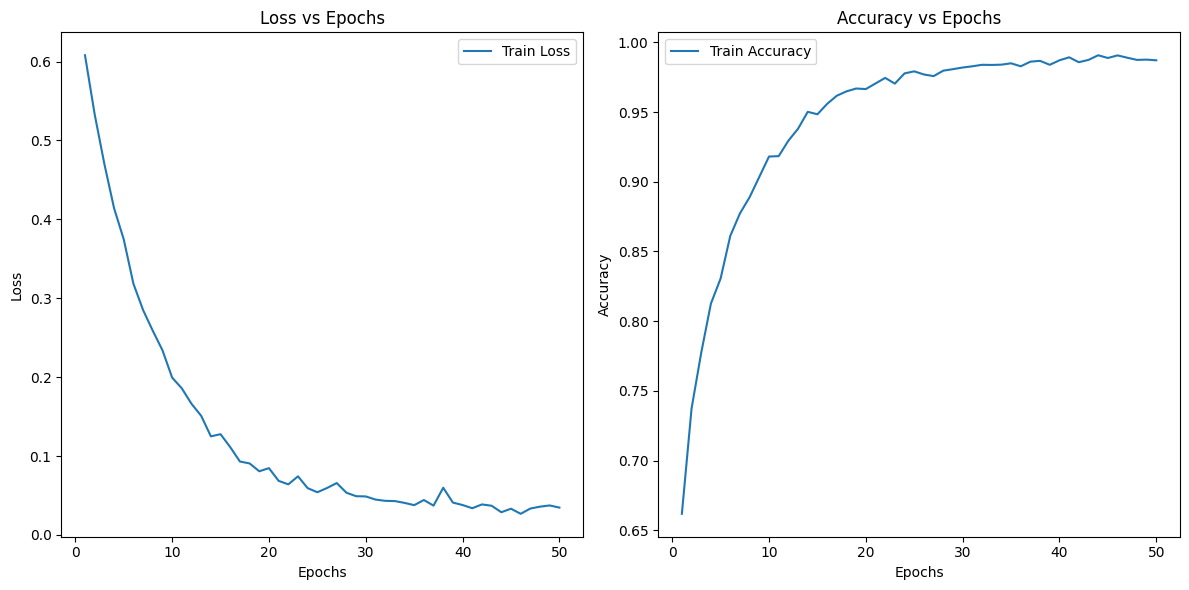

In [11]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_acc, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


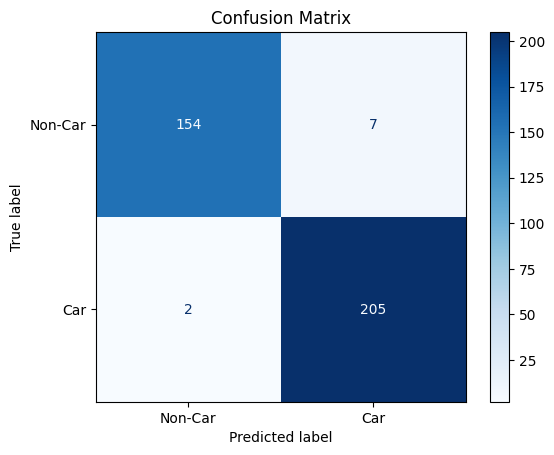

Validation Accuracy: 0.9755
Confusion Matrix:


,Non-Car,Car
Non-Car,154,7
Car,2,205


In [15]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (outputs.squeeze() > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Car', 'Car'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Print validation accuracy
val_accuracy = accuracy_score(all_labels, all_preds)
print(f'Validation Accuracy: {val_accuracy:.4f}')

class_labels = ['Non-Car', 'Car']

# Create a DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Print the confusion matrix with labels
print("Confusion Matrix:")
cm_df


# Step 5: Sliding Window Approach for Testing:

1. **Device Setup**:
   - The model is set to use a GPU if available, or a CPU otherwise.

2. **Test Image Loading**:
   - Images from a specified test directory are loaded. The test images are expected to be in grayscale format with `.pgm` extension.

3. **Sliding Window Detection**:
   - A sliding window is used to scan through each test image to identify regions of interest.
   - The parameters for the sliding window include:
     - Window size: \(100 \times 40\) (width × height).
     - Step size: Determines how far the window moves horizontally and vertically during the scan.

4. **Preprocessing**:
   - Each window is resized to a fixed dimension, normalized (pixel values scaled between 0 and 1), and reshaped into a format compatible with the model (channel-first order).

5. **Prediction**:
   - The preprocessed window is fed into the trained model, which outputs a probability score indicating whether the region contains a car.
   - A detection threshold of 0.6 is used to classify a region as containing a car.

6. **Non-Maximum Suppression (NMS)**:
   - To handle overlapping detections, NMS is applied. This ensures that only the most confident predictions for each car location are retained.

7. **Output**:
   - For each test image, the detected car locations are written to an output file (`foundLocations.txt`) in the format:
     - `image_index: (row, col) (row, col) ...`
   - If no detections are found for an image, an empty line is written.

This approach ensures a systematic scan of test images, allowing the model to detect potential cars and output their locations in a structured format.


To properly evaluate the model's performance on the test data, please follow the instructions outlined in the `Readme.md` file within the `CarData` folder.

In [8]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Directory paths
test_img_dir = './CarData/TestImages/'
output_file_path = './CarData/foundLocations.txt'

# Load test images
test_images = [f for f in os.listdir(test_img_dir) if f.endswith('.pgm')]

# Open the output file in write mode
with open(output_file_path, 'w') as output_file:
    # Process each image
    for img_idx, img_filename in enumerate(test_images):
        # Load the test image
        test_img_path = os.path.join(test_img_dir, img_filename)
        test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image is loaded successfully
        if test_img is None:
            output_file.write(f"{img_idx}:\n")  # Write an empty line if the image could not be loaded
            continue

        # Get the dimensions of the test image
        img_height, img_width = test_img.shape

        # Define sliding window parameters
        window_height, window_width = 40, 100
        step_size = 5  # Adjust step size as needed

        # Lists to store bounding boxes and scores
        boxes = []
        scores = []

        # Slide window over the image
        for y in range(0, img_height - window_height + 1, step_size):
            for x in range(0, img_width - window_width + 1, step_size):
                # Extract the window
                window = test_img[y:y+window_height, x:x+window_width]

                # Preprocess the window (resize, normalize, and add channel dimension)
                window_resized = cv2.resize(window, (100, 40))
                window_resized = window_resized.astype('float32') / 255.0
                window_resized = np.expand_dims(window_resized, axis=-1)
                window_tensor = torch.tensor(window_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

                # Perform prediction
                model.eval()
                with torch.no_grad():
                    prediction = model(window_tensor).squeeze().item()

                # If prediction exceeds threshold, record detection
                if prediction > 0.6:
                    boxes.append([x, y, x + window_width, y + window_height])
                    scores.append(prediction)

        # Apply Non-Maximum Suppression (NMS)
        detected_coordinates = []
        if boxes:
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
            scores_tensor = torch.tensor(scores, dtype=torch.float32)
            indices = ops.nms(boxes_tensor, scores_tensor, 0.3)  # NMS threshold = 0.3

            for i in indices:
                x1, y1, x2, y2 = boxes_tensor[i].tolist()
                detected_coordinates.append((int(y1), int(x1)))

        # Write detections to output file
        output_file.write(f"{img_idx}: ")
        if detected_coordinates:
            for coord in detected_coordinates:
                output_file.write(f"({coord[0]},{coord[1]}) ")
        output_file.write("\n")  # Ensure an empty line if no detections


'# Set device\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\n\n# Directory paths\ntest_img_dir = \'./CarData/TestImages/\'\noutput_file_path = \'./CarData/foundLocations.txt\'\n\n# Load test images\ntest_images = [f for f in os.listdir(test_img_dir) if f.endswith(\'.pgm\')]\n\n# Open the output file in write mode\nwith open(output_file_path, \'w\') as output_file:\n    # Process each image\n    for img_idx, img_filename in enumerate(test_images):\n        # Load the test image\n        test_img_path = os.path.join(test_img_dir, img_filename)\n        test_img = cv2.imread(test_img_path, cv2.IMREAD_GRAYSCALE)\n\n        # Check if the image is loaded successfully\n        if test_img is None:\n            output_file.write(f"{img_idx}:\n")  # Write an empty line if the image could not be loaded\n            continue\n\n        # Get the dimensions of the test image\n        img_height, img_width = test_img.shape\n\n        # Define sliding wind